In [1]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.2 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
# CÀI ĐẶT VÀ THIẾT LẬP THƯ VIỆN CẦN THIẾT
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle
import time
import json
from tqdm import tqdm
from collections import Counter
from pathlib import Path
import joblib

# Thư viện cho CNN và Tải mô hình
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import save_model

# Thư viện cho các mô hình ML truyền thống và đánh giá
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE # Thư viện để xử lý mất cân bằng

2025-11-26 13:59:01.585456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764165541.810256      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764165541.877484      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# Thiết lập đường dẫn cơ sở của dataset trên Kaggle
# Tên thư mục dữ liệu trên Kaggle thường là tên dataset sau khi thêm vào Notebook
DATASET_TRAIN_PATH = "/kaggle/input/animal-sea-split-data/split_data/train"
DATASET_TEST_PATH = "/kaggle/input/animal-sea-split-data/split_data/test"

# Đọc và gán dữ liệu cho dữ liệu

In [4]:
def generate_df(image_dir):
    image_dir = Path(image_dir)
    
    # Lấy tất cả các file ảnh (jpg, jpeg, png, bmp...)
    # glob('**/*') sẽ duyệt đệ quy vào các thư mục con
    filepaths = list(image_dir.glob(r'**/*.*'))
    
    # Lọc chỉ lấy file ảnh (tránh file hệ thống)
    img_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.gif']
    filepaths = [x for x in filepaths if x.suffix.lower() in img_extensions]

    # Tạo labels dựa trên tên folder cha
    labels = [x.parent.name for x in filepaths]
    
    # Chuyển đổi thành string path để dễ xử lý sau này
    filepaths_str = [str(x) for x in filepaths]

    df = pd.DataFrame({
        'filepath': filepaths_str,
        'class': labels
    })
    
    return df

In [5]:
train_df = generate_df(DATASET_TRAIN_PATH)
test_df = generate_df(DATASET_TEST_PATH)

In [6]:
train_df

,filepath,class
0,/kaggle/input/animal-sea-split-data/split_data...,Penguin
1,/kaggle/input/animal-sea-split-data/split_data...,Penguin
2,/kaggle/input/animal-sea-split-data/split_data...,Penguin
3,/kaggle/input/animal-sea-split-data/split_data...,Penguin
4,/kaggle/input/animal-sea-split-data/split_data...,Penguin
...,...,...
10978,/kaggle/input/animal-sea-split-data/split_data...,Jelly Fish
10979,/kaggle/input/animal-sea-split-data/split_data...,Jelly Fish
10980,/kaggle/input/animal-sea-split-data/split_data...,Jelly Fish
10981,/kaggle/input/animal-sea-split-data/split_data...,Jelly Fish


In [7]:
print(f"\nPhân bố lớp trong tập TRAIN (Tỷ lệ):\n{train_df['class'].value_counts(normalize=True).sort_index()}")
print(f"Phân bố lớp trong tập TEST (Tỷ lệ):\n{test_df['class'].value_counts(normalize=True).sort_index()}")



Phân bố lớp trong tập TRAIN (Tỷ lệ):
class
Clams              0.036238
Corals             0.036420
Crabs              0.036329
Dolphin            0.056906
Eel                0.036238
Fish               0.035965
Jelly Fish         0.061550
Lobster            0.036329
Nudibranchs        0.036420
Octopus            0.040972
Otter              0.036420
Penguin            0.035145
Puffers            0.038696
Sea Rays           0.037695
Sea Urchins        0.042156
Seahorse           0.034781
Seal               0.030137
Sharks             0.042976
Shrimp             0.035509
Squid              0.035145
Starfish           0.036329
Turtle_Tortoise    0.138578
Whale              0.043067
Name: proportion, dtype: float64
Phân bố lớp trong tập TEST (Tỷ lệ):
class
Clams              0.036092
Corals             0.036456
Crabs              0.036456
Dolphin            0.057237
Eel                0.036092
Fish               0.036092
Jelly Fish         0.061611
Lobster            0.036456
Nudibranchs  

In [8]:
class_names = sorted(train_df['class'].unique())
class_names

['Clams',
 'Corals',
 'Crabs',
 'Dolphin',
 'Eel',
 'Fish',
 'Jelly Fish',
 'Lobster',
 'Nudibranchs',
 'Octopus',
 'Otter',
 'Penguin',
 'Puffers',
 'Sea Rays',
 'Sea Urchins',
 'Seahorse',
 'Seal',
 'Sharks',
 'Shrimp',
 'Squid',
 'Starfish',
 'Turtle_Tortoise',
 'Whale']

In [9]:
with open('/kaggle/input/animal-sea-split-data/split_data/class_mapping.json', 'r') as f:
    label_map = json.load(f)

# Tạo danh sách class names theo đúng thứ tự index từ 0 -> 22
# Đảm bảo key trong json là string, cần convert sang int để sort
sorted_indices = sorted([int(k) for k in label_map.keys()])
class_names_ordered = [label_map[str(i)] for i in sorted_indices]

print("Thứ tự lớp cố định theo JSON:", class_names_ordered)
NUM_CLASSES = len(class_names_ordered)

Thứ tự lớp cố định theo JSON: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


# Tiền xử lý dữ liệu và chuẩn hóa dữ liệu đầu vào

In [10]:
# 3. Tạo ImageDataGenerator từ DataFrame
# Tiền xử lý ảnh ResNet50 được áp dụng tại đây
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generator cho tập Huấn luyện (Train)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    classes=class_names_ordered # Đảm bảo thứ tự lớp là nhất quán
)

# Generator cho tập Kiểm tra (Test)
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False, # Không xáo trộn khi trích xuất
    classes=class_names_ordered
)

print("\nĐã tạo Train và Test Generators bằng Stratified Split.")

Found 10983 validated image filenames belonging to 23 classes.
Found 2743 validated image filenames belonging to 23 classes.

Đã tạo Train và Test Generators bằng Stratified Split.


# Trích xuất đặc trưng

In [11]:
# Tải mô hình ResNet50 đã được huấn luyện trên ImageNet
# include_top=False: Loại bỏ lớp phân loại cuối cùng
# pooling='avg': Áp dụng Global Average Pooling, trả về vector đặc trưng kích thước (None, 2048)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Tạo mô hình Feature Extractor
# Đầu vào là đầu vào của ResNet50, Đầu ra là vector đặc trưng từ lớp Global Average Pooling
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

print("Đã tải mô hình ResNet50 và thiết lập Feature Extractor.")
print(f"Kích thước vector đặc trưng đầu ra: {feature_extractor.output_shape}")

I0000 00:00:1764165595.385008      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764165595.385617      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Đã tải mô hình ResNet50 và thiết lập Feature Extractor.
Kích thước vector đặc trưng đầu ra: (None, 2048)


In [12]:
# TRÍCH XUẤT ĐẶC TRƯNG TỪ CÁC GENERATOR

def extract_features(generator, model):
    """Trích xuất đặc trưng và nhãn số nguyên từ ImageDataGenerator."""
    num_samples = generator.samples
    
    # Feature vẫn giữ nguyên (None, 2048)
    features = np.zeros(shape=(num_samples, 2048))
    
    # Label bây giờ là mảng 1 chiều chứa số nguyên
    labels = np.zeros(shape=(num_samples,)) 

    i = 0
    print(f"Bắt đầu trích xuất {num_samples} mẫu...")
    
    # Reset generator về đầu để đảm bảo đồng bộ
    generator.reset()
    
    for inputs_batch, labels_batch in tqdm(generator, total=len(generator)):
        # Trích xuất đặc trưng
        feature_batch = model.predict(inputs_batch, verbose=0)
        
        # Lưu vào mảng features và labels
        start_index = i * BATCH_SIZE
        end_index = min((i + 1) * BATCH_SIZE, num_samples)
        
        # Lấy đúng số lượng mẫu thực tế trong batch (xử lý batch cuối bị lẻ)
        current_batch_size = feature_batch.shape[0]
        
        features[start_index : start_index + current_batch_size] = feature_batch
        labels[start_index : start_index + current_batch_size] = labels_batch
        
        i += 1
        if i >= len(generator):
            break 

    return features, labels

In [13]:
# 1. Trích xuất cho Tập Huấn luyện
train_features, train_labels = extract_features(train_generator, feature_extractor)
test_features, test_labels = extract_features(test_generator, feature_extractor)

print("\nTrích xuất đặc trưng hoàn tất!")
print(f"Kích thước tập Train Features: {train_features.shape}")
print(f"Kích thước tập Test Features: {test_features.shape}")

Bắt đầu trích xuất 10983 mẫu...


  0%|          | 0/344 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1764165600.405433     119 service.cc:148] XLA service 0x786ad4149f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764165600.406573     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764165600.406592     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764165601.046983     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764165605.132202     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|█████████▉| 343/344 [01:54<00:00,  2.98it/s]


Bắt đầu trích xuất 2743 mẫu...


 99%|█████████▉| 85/86 [00:28<00:00,  2.94it/s]


Trích xuất đặc trưng hoàn tất!
Kích thước tập Train Features: (10983, 2048)
Kích thước tập Test Features: (2743, 2048)


# Chuẩn hóa dữ liệu sau khi trích xuất đặc trưng

In [14]:
X_train = train_features
y_train = train_labels
X_test = test_features
y_test = test_labels

In [15]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()

print("\nTiến hành chuẩn hóa dữ liệu sau khi trích xuất đặc trưng")

X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)       

print("\nĐã Chuẩn hóa đặc trưng (Feature Scaling) bằng StandardScaler.")


Tiến hành chuẩn hóa dữ liệu sau khi trích xuất đặc trưng

Đã Chuẩn hóa đặc trưng (Feature Scaling) bằng StandardScaler.


In [16]:
# Lưu lại bộ scaler để sau này deploy
joblib.dump(scaler, "/kaggle/working/scaler_resnet_feature_extraction.pkl")

['/kaggle/working/scaler_resnet_feature_extraction.pkl']

# Model Training & Evaluation

## SVC Model

In [17]:
svc_model = SVC(kernel='linear', C=1.0, random_state=42, class_weight='balanced') 

print("Bắt đầu huấn luyện mô hình SVM...")

# 2. Huấn luyện mô hình
svc_model.fit(X_train, y_train)

print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện mô hình SVM...
Huấn luyện hoàn tất!



Độ chính xác (Accuracy) trên tập Test: 0.8163

-------------------- BÁO CÁO PHÂN LOẠI --------------------
                 precision    recall  f1-score   support

          Clams       0.65      0.69      0.67        99
         Corals       0.56      0.72      0.63       100
          Crabs       0.97      0.98      0.98       100
        Dolphin       0.83      0.87      0.85       157
            Eel       0.64      0.70      0.67        99
           Fish       0.59      0.62      0.60        99
     Jelly Fish       0.92      0.93      0.93       169
        Lobster       0.80      0.85      0.83       100
    Nudibranchs       0.78      0.80      0.79       100
        Octopus       0.71      0.62      0.66       112
          Otter       1.00      1.00      1.00       100
        Penguin       0.82      0.83      0.82        96
        Puffers       0.75      0.70      0.72       106
       Sea Rays       0.73      0.74      0.73       103
    Sea Urchins       0.97      0.99

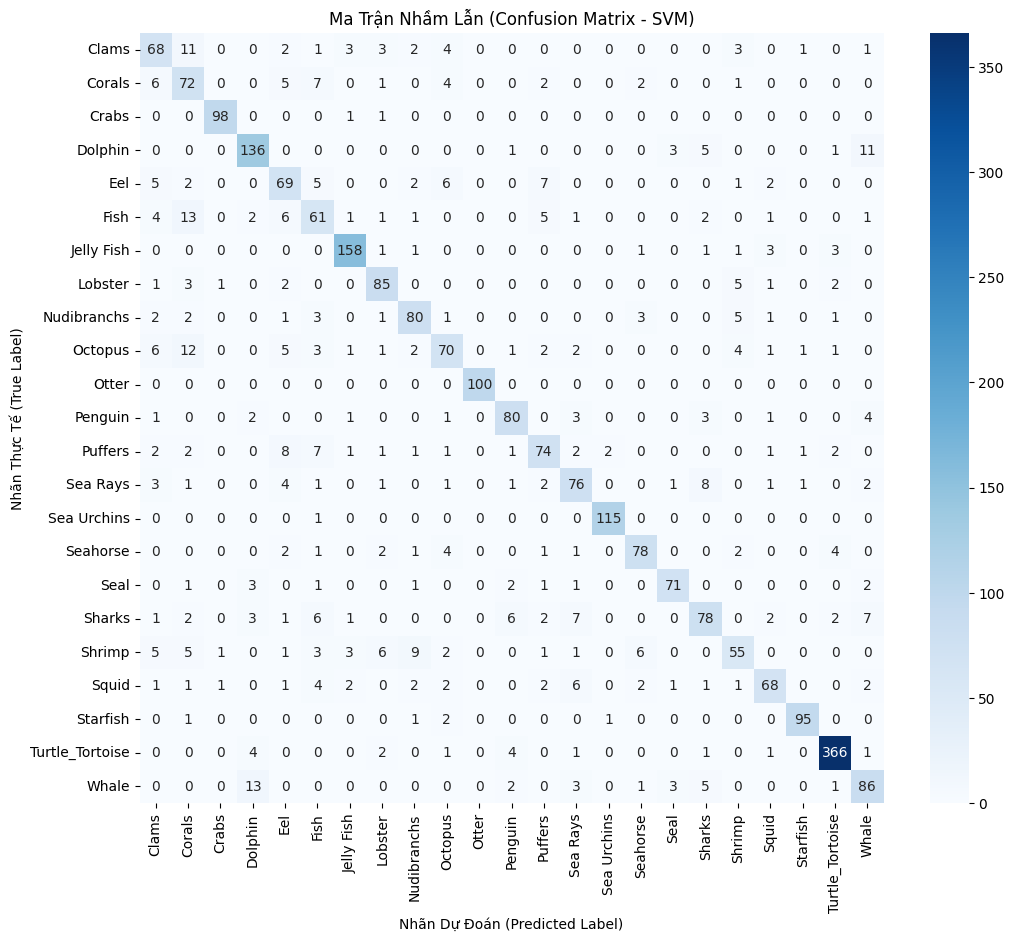

In [18]:
# 3. Dự đoán trên tập kiểm tra (Sử dụng X_test GỐC)
y_pred_svc = svc_model.predict(X_test)

# 4. Đánh giá kết quả
accuracy = accuracy_score(y_test, y_pred_svc)
print(f"\nĐộ chính xác (Accuracy) trên tập Test: {accuracy:.4f}")

print("\n-------------------- BÁO CÁO PHÂN LOẠI --------------------")
target_names = class_names # Lấy tên lớp từ Cell 1
print(classification_report(y_test, y_pred_svc, target_names=target_names))

# 5. Ma trận nhầm lẫn (Confusion Matrix)
conf_matrix = confusion_matrix(y_test, y_pred_svc)
print("\n-------------------- MA TRẬN NHẦM LẪN --------------------")

# ********* TRỰC QUAN HÓA BẰNG SEABORN *********
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix, 
    annot=True,          # Hiển thị giá trị số
    fmt='d',             # Định dạng số nguyên
    cmap='Blues',        # Bảng màu
    xticklabels=class_names_ordered, # Nhãn trục X (Dự đoán)
    yticklabels=class_names_ordered  # Nhãn trục Y (Thực tế)
)
plt.title('Ma Trận Nhầm Lẫn (Confusion Matrix - SVM)')
plt.ylabel('Nhãn Thực Tế (True Label)')
plt.xlabel('Nhãn Dự Đoán (Predicted Label)')
plt.show()

# **********************************************

# Lưu mô hình và trích xuất đặc trưng

In [19]:
# Thư mục để lưu các file
DEPLOYMENT_FOLDER = '/kaggle/working/deployment_assets'
os.makedirs(DEPLOYMENT_FOLDER, exist_ok=True)
print(f"Các file sẽ được lưu tại: {DEPLOYMENT_FOLDER}")

# Danh sách các mô hình ML và tên tệp tương ứng
ml_models_to_save = {
    'svc_model': svc_model,
}

# ************************************************************
# 1. LƯU MÔ HÌNH FEATURE EXTRACTOR (ResNet50)
# ************************************************************
extractor_path = os.path.join(DEPLOYMENT_FOLDER, 'resnet50_feature_extractor.h5')
feature_extractor.save(extractor_path)
print(f"Đã lưu ResNet50 Feature Extractor tại: {extractor_path}")


# ************************************************************
# 2. LƯU CẢ 3 MÔ HÌNH PHÂN LOẠI ML (Random Forest, SVM, LR)
# ************************************************************
for name, model in ml_models_to_save.items():
    classifier_path = os.path.join(DEPLOYMENT_FOLDER, f'{name}.pkl')
    with open(classifier_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Đã lưu {name.replace('_', ' ').title()} tại: {classifier_path}")


# ************************************************************
# 4. KIỂM TRA CÁC FILE ĐÃ LƯU
# ************************************************************
print("\nDanh sách các file đã lưu để Deploy:")
print(os.listdir(DEPLOYMENT_FOLDER))

Các file sẽ được lưu tại: /kaggle/working/deployment_assets
Đã lưu ResNet50 Feature Extractor tại: /kaggle/working/deployment_assets/resnet50_feature_extractor.h5
Đã lưu Svc Model tại: /kaggle/working/deployment_assets/svc_model.pkl

Danh sách các file đã lưu để Deploy:
['svc_model.pkl', 'resnet50_feature_extractor.h5']


# Tinh chỉnh các tham số của các mô hình

## Thiết lập các bộ tham số

In [20]:
# 1. Định nghĩa không gian tham số (Parameter Grids)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],
}

svc = SVC(class_weight='balanced') 

## Thực hiện tinh cỉnh cho 3 mô hình RandomForest, SVC, Logistic Regression

In [21]:
# Sử dụng RandomizedSearchCV
start_time = time.time()

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
   
grid_search.fit(X_train, y_train)
    
end_time = time.time()
    
# Lưu mô hình tốt nhất
best_model = grid_search.best_estimator_
    
print(f"Thời gian: {end_time - start_time:.2f}s")
print(f"Tham số Tốt nhất: {grid_search.best_params_}")
print(f"Độ chính xác CV Tốt nhất: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Thời gian: 274.17s
Tham số Tốt nhất: {'C': 0.1, 'kernel': 'linear'}
Độ chính xác CV Tốt nhất: 0.7815


## Đánh giá kết quả sau khi tunning



--- ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH SVC TỐT NHẤT TRÊN TẬP TEST ---
Độ chính xác (Accuracy) trên tập Test: 0.8192
                 precision    recall  f1-score   support

          Clams       0.68      0.69      0.68        99
         Corals       0.57      0.73      0.64       100
          Crabs       0.97      0.98      0.98       100
        Dolphin       0.84      0.87      0.85       157
            Eel       0.66      0.70      0.68        99
           Fish       0.60      0.66      0.63        99
     Jelly Fish       0.92      0.93      0.93       169
        Lobster       0.80      0.85      0.83       100
    Nudibranchs       0.78      0.80      0.79       100
        Octopus       0.71      0.62      0.66       112
          Otter       1.00      1.00      1.00       100
        Penguin       0.81      0.82      0.82        96
        Puffers       0.75      0.73      0.74       106
       Sea Rays       0.73      0.73      0.73       103
    Sea Urchins       0.97      0.

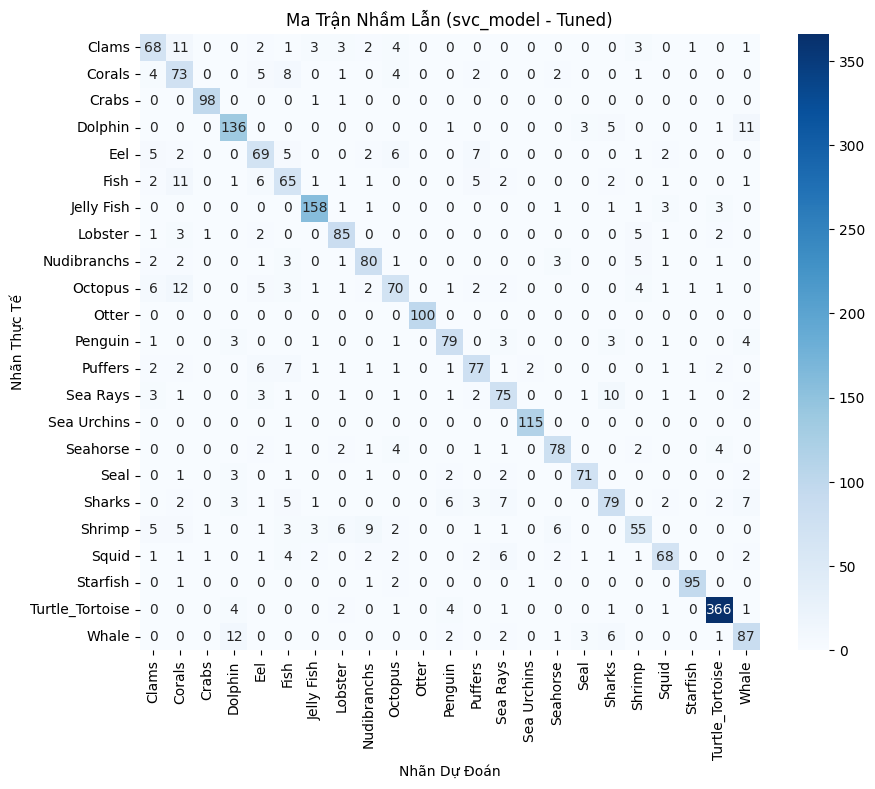

In [22]:
# 3. Đánh giá và Trực quan hóa kết quả Cuối cùng
# (Giữ nguyên phần này để có rf_model, svm_model, lr_model cho các Cell sau)
# ... (Phần đánh giá hiệu suất và vẽ Confusion Matrix sẽ theo sau, tương tự như bản trước) ...

# Các mô hình đã được tinh chỉnh cuối cùng

print("\n\n--- ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH SVC TỐT NHẤT TRÊN TẬP TEST ---")

# Dự đoán trên tập kiểm tra (X_test GỐC)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
    
print(f"Độ chính xác (Accuracy) trên tập Test: {accuracy:.4f}")
    
# Báo cáo Phân loại
target_names = class_names 
print(classification_report(y_test, y_pred, target_names=target_names))
    
# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names_ordered, 
    yticklabels=class_names_ordered
)
plt.title(f'Ma Trận Nhầm Lẫn ({name} - Tuned)')
plt.ylabel('Nhãn Thực Tế')
plt.xlabel('Nhãn Dự Đoán')
plt.show()

In [23]:
DEPLOYMENT_FOLDER = '/kaggle/working/deployment_assets_tunning'
os.makedirs(DEPLOYMENT_FOLDER, exist_ok=True)
print(f"Các file sẽ được lưu tại: {DEPLOYMENT_FOLDER}")

# Danh sách các mô hình ML đã được tinh chỉnh và tên tệp tương ứng
ml_models_to_save = {
    'svc_model_tuned': best_model, 
}

# ************************************************************
for name, model in ml_models_to_save.items():
    classifier_path = os.path.join(DEPLOYMENT_FOLDER, f'{name}.pkl')
    # Lưu mô hình Scikit-learn bằng pickle
    with open(classifier_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Đã lưu {name.replace('_', ' ').title()} tại: {classifier_path}")
    

Các file sẽ được lưu tại: /kaggle/working/deployment_assets_tunning
Đã lưu Svc Model Tuned tại: /kaggle/working/deployment_assets_tunning/svc_model_tuned.pkl
